In [1]:
import torch
import torchmin.bfgs as bfs
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import torchmin.benchmarks as bm
from opti_utils import BFGS,strong_wolfe,f,logistic

In [2]:
batchsize=128
DIM=10

In [3]:
USE_CUDA=False
if torch.cuda.is_available():
    USE_CUDA=True
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
USE_CUDA

True

## BFGS

200


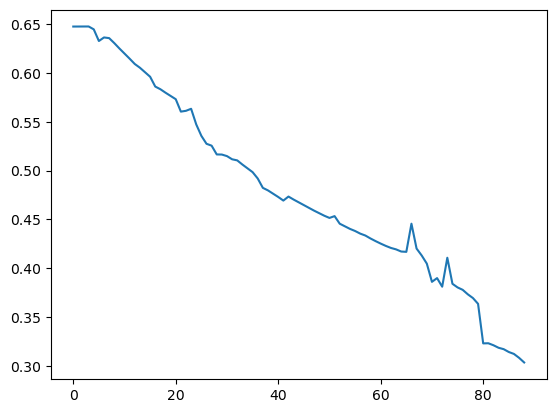

In [4]:
W = torch.randn((batchsize, DIM, DIM), device=device) # represents IID
Y = torch.rand((batchsize,DIM),device=device)
x = torch.ones((batchsize,DIM),device=device,requires_grad=True)

steps=200
B=BFGS(batchsize,DIM,device,x)
mem_loss=[]
loss=logistic(W,Y,x,2,DIM)
acc=1e-6
mem_loss.append(loss.mean())
g=torch.autograd.grad(loss.mean(),x)[0]
d=-torch.matmul(B.H,g.unsqueeze(2))
k=0
#print(loss)
for i in range(steps):
    g_pre=g
    alpha=strong_wolfe(W,Y,batchsize,f, x, d, loss, g, c1=1e-4, c2=0.9, max_iter=10,device=device)
    update=alpha*(d.squeeze())
    x=x+update
    loss=logistic(W,Y,x,2,DIM)
    mem_loss.append(loss.mean())
    g=torch.autograd.grad(loss.mean(),x)[0]
    #print(torch.norm(g,dim=1).mean())
    if(sum(torch.norm(g,dim=1)<acc)>0):
        break
    d=-torch.matmul(B.H,g.unsqueeze(2))
    #print(B.H)
    B.H_BFDS_update(update,g-g_pre)
    k+=1
    
print(k)    
plt.plot([i.cpu().detach().numpy() for i in mem_loss])  

## LSTM define

In [5]:
class LSTM_motify(torch.nn.Module):
    """LSTM修正器
       LSTM optimizer"""
    
    def __init__(self,input_size,output_size, hidden_size, num_stacks, batchsize,p  = 10 ,preprocess = True, output_scale = 1):
        super(LSTM_motify,self).__init__()
        self.preprocess_flag = preprocess
        self.input_flag = 2
        if preprocess != True:
             self.input_flag = 1
        self.p = p
        self.output_scale = output_scale 
        self.lstm = torch.nn.LSTM(input_size*self.input_flag, hidden_size, num_stacks)
        self.Linear = torch.nn.Linear(hidden_size,output_size) #1-> output_size
        print(self.preprocess_flag)
        
    def LogAndSign_Preprocess_Gradient(self,gradients):
        """
        Args:
          gradients: `Tensor` of gradients with shape `[d_1, ..., d_n]`.
          p       : `p` > 0 is a parameter controlling how small gradients are disregarded 
        Returns:
          `Tensor` with shape `[d_1, ..., d_n-1, 2 * d_n]`. The first `d_n` elements
          along the nth dimension correspond to the `log output` \in [-1,1] and the remaining
          `d_n` elements to the `sign output`.
        """
        p  = self.p
        log = torch.log(torch.abs(gradients))
        clamp_log = torch.clamp(log/p , min = -1.0,max = 1.0)
        clamp_sign = torch.clamp(torch.exp(torch.tensor(p))*gradients, min = -1.0, max =1.0)
        return torch.cat((clamp_log,clamp_sign),dim = -1) #在gradients的最后一维input_dims拼接
    
    def Output_motification_And_motify_LSTM_Hidden_State(self, input_gradients, prev_state):
        """LSTM的核心操作  core operation
        coordinate-wise LSTM """
        if prev_state is None: #init_state
            prev_state = (torch.zeros(Layers,batchsize,Hidden_nums),
                            torch.zeros(Layers,batchsize,Hidden_nums))
            if USE_CUDA :
                 prev_state = (torch.zeros(Layers,batchsize,Hidden_nums).cuda(),
                            torch.zeros(Layers,batchsize,Hidden_nums).cuda())
         			
        motify , next_state = self.lstm(input_gradients, prev_state)
        motify = self.Linear(motify) * self.output_scale # transform the LSTM output to the target output dim 
        return motify, next_state
    
    def forward(self,input_data, prev_state):
        if USE_CUDA:
            input_data = input_data.cuda()
        #pytorch requires the `torch.nn.lstm`'s input as（1，batchsize,input_dim）
        # original gradient.size()=torch.size[5] ->[1,1,5]
        # gradients = move_gradients.unsqueeze(0)
        # moves = move.unsqueeze(0)
        # combined = torch.cat((moves, gradients), dim=0)
        if self.preprocess_flag == True:
            #print(input_data.shape)
            input_data = self.LogAndSign_Preprocess_Gradient(input_data)
        motify , next_state = self.Output_motification_And_motify_LSTM_Hidden_State(input_data , prev_state)
        # Squeeze to make it a single batch again.[1,1,5]->[5]
        motify = motify.squeeze().squeeze()
       
        return motify , next_state

In [6]:
Layers = 2
Hidden_nums = 20
Input_DIM = DIM*2
Output_DIM = DIM
output_scale_value=1

#######   构造一个优化器  #######
#######  construct a optimizer  #######
LSTM_motify = LSTM_motify(Input_DIM, Output_DIM, Hidden_nums ,Layers , batchsize=batchsize,\
                preprocess=False,output_scale=output_scale_value)
print(LSTM_motify)

if USE_CUDA:
    LSTM_optimizer = LSTM_motify.cuda()

False
LSTM_motify(
  (lstm): LSTM(20, 20, num_layers=2)
  (Linear): Linear(in_features=20, out_features=10, bias=True)
)


## LSTM pre-train vs BFGS

In [7]:
import time

In [8]:
def record(loss,standard='mean',num=0):
    if standard=='mean':
        return loss.mean()
    else:
        return loss[num]

In [9]:
def LSTM_iter(W,Y,x,batchsize,DIM,device,standard='mean',rec_num=0,steps=200,acc=1e-6,plot=False,lam=2):    
    start_time=time.time()
    state=None#初始化LSTM hidden state
    H=torch.eye(DIM, device=x.device, dtype=x.dtype,requires_grad=True).unsqueeze(0).expand(batchsize, -1, -1)
    mem_loss=[]#初始化loss的list
    loss=logistic(W,Y,x,lam,DIM)#每个case的loss
    global_loss_graph = 0#记录每个迭代的总loss 用于后向传播
    lossmean=loss.mean()#总loss的平均值

    global_loss_graph+=lossmean
    mem_loss.append(loss[rec_num])

    lossmean.backward(retain_graph=True)
    g = x.grad.clone()#g detach掉
    d=-torch.matmul(H,g.unsqueeze(2))
    k=0
    #print(loss)
    for i in range(steps):
        g_pre=g.clone()# 保存g作为上一次的g，此时g_pre不在计算图中
        alpha=strong_wolfe(W,Y,batchsize,f, x, d, loss, g, c1=1e-4, c2=0.9, max_iter=10,device=device)
        alpha.detach_()
        update=alpha*d.squeeze()
        # update=d.squeeze()
        x=x+update
        x.retain_grad()
        loss=logistic(W,Y,x,lam,DIM)
        lossmean=loss.mean()
        global_loss_graph+=lossmean
        mem_loss.append(loss[rec_num])
        #print(mem_loss[0])
        lossmean.backward(retain_graph=True)
        #print([i.grad for i in LSTM_motify.parameters()])
        #print(g)
        g = x.grad.clone()
        #print(torch.norm(g,dim=1).mean())
        if(sum(torch.norm(g,dim=1)<acc)>0):
            break
        #print(B.H)
        input_vec=torch.cat((g,update),dim=1).unsqueeze(0)
        #print(input_vec.is_leaf)
        motify,state=LSTM_motify(input_vec,state)
        deltaH=motify.reshape((batchsize, DIM, 1))
        H = H.clone().detach() + deltaH*deltaH.transpose(1, 2)
        H.retain_grad()
        d=-torch.matmul(H,g.unsqueeze(2))
        k+=1
    if plot:
        plt.plot([i.cpu().detach().numpy() for i in mem_loss],label='LSTM')
        end_time = time.time()
        LSTM_time = end_time - start_time
    return mem_loss,global_loss_graph,LSTM_time

In [10]:
def BFGS_iter(W,Y,x,batchsize,DIM,device,standard='mean',rec_num=0,steps=200,acc=1e-6,plot=False,lam=2):
    start_time=time.time()
    B=BFGS(batchsize,DIM,device,x)
    mem_loss=[]
    loss=logistic(W,Y,x,lam,DIM)
    acc=1e-6
    global_loss=0
    lossmean=loss.mean()
    global_loss+=lossmean
    mem_loss.append(loss[rec_num])
    g=torch.autograd.grad(loss.mean(),x)[0]
    d=-torch.matmul(B.H,g.unsqueeze(2))
    k=0
    #print(loss)
    for i in range(steps):
        g_pre=g
        alpha=strong_wolfe(W,Y,batchsize,f, x, d, loss, g, c1=1e-4, c2=0.9, max_iter=10,device=device)
        update=alpha*(d.squeeze())
        x=x+update
        loss=logistic(W,Y,x,lam,DIM)
        lossmean=loss.mean()
        global_loss+=lossmean
        mem_loss.append(loss[rec_num])
        g=torch.autograd.grad(lossmean,x)[0]
        #print(torch.norm(g,dim=1).mean())
        if(sum(torch.norm(g,dim=1)<acc)>0):
            break
        d=-torch.matmul(B.H,g.unsqueeze(2))
        #print(B.H)
        B.H_BFDS_update(update,g-g_pre)
        k+=1

    end_time = time.time()
    BFGS_time = end_time - start_time
    if plot:
        plt.plot([i.cpu().detach().numpy() for i in mem_loss],label='BFGS')  
    return mem_loss,global_loss,BFGS_time

In [11]:
def gradient_iter(W,Y,x,batchsize,DIM,device,standard='mean',rec_num=0,steps=200,acc=1e-6,plot=False):    
    start_time=time.time()
    mem_loss=[]#初始化loss的list
    loss=f(W,Y,x)#每个case的loss
    global_loss_graph = 0#记录每个迭代的总loss 用于后向传播
    lossmean=loss.mean()#总loss的平均值

    global_loss_graph+=lossmean
    mem_loss.append(loss[rec_num])

    lossmean.backward(retain_graph=True)
    g = x.grad
    k=0
    #print(loss)
    for i in range(steps):
        # update=d.squeeze()
        x=x-g
        x.retain_grad()
        loss=f(W,Y,x)
        lossmean=loss.mean()
        global_loss_graph+=lossmean
        mem_loss.append(loss[rec_num])
        #print(mem_loss[0])
        lossmean.backward(retain_graph=True)
        #print([i.grad for i in LSTM_motify.parameters()])
        #print(g)
        g = x.grad
        #print(torch.norm(g,dim=1).mean())
        if(sum(torch.norm(g,dim=1)<acc)>0):
            break
        #print(B.H)
        #print(input_vec.is_leaf)
        k+=1
    if plot:
        plt.plot([i.cpu().detach().numpy() for i in mem_loss],label='Gradient')
        end_time = time.time()
        LSTM_time = end_time - start_time
    return mem_loss,global_loss_graph,LSTM_time

bfgs_time 1.7335681915283203
lstm_time 10.497685670852661


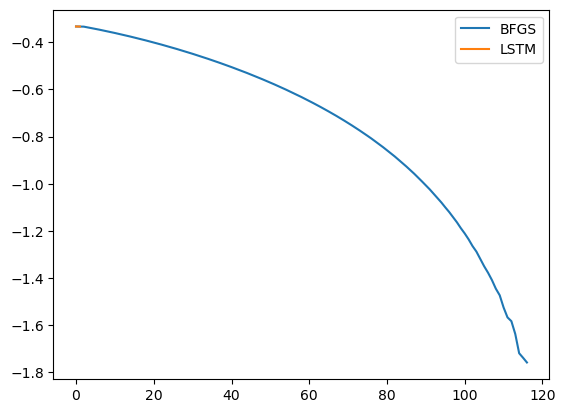

: 

In [28]:
batchsize=1
W = torch.randn((batchsize, DIM, DIM), device=device) # represents IID
Y = torch.rand((batchsize,DIM),device=device)
x = torch.ones((batchsize,DIM),device=device,requires_grad=True)
bfgs_loss,bfgs_tot_loss,bfgs_time=BFGS_iter(W,Y,x,batchsize,DIM,device,rec_num=0,standard='mean',acc=1e-6,plot=True,lam=0.7)
x = torch.ones((batchsize,DIM),device=device,requires_grad=True)
lstm_loss,lstm_tot_loss,lstm_time=LSTM_iter(W,Y,x,batchsize,DIM,device,rec_num=0,standard='mean',acc=1e-6,plot=True,lam=0.7)
print('bfgs_time',bfgs_time)
print('lstm_time',lstm_time)
#grad_loss,grad_tot_loss,grad_time=gradient_iter(W,Y,x,batchsize,DIM,device,rec_num=0,standard='mean',acc=1e-6,plot=True)
plt.legend()

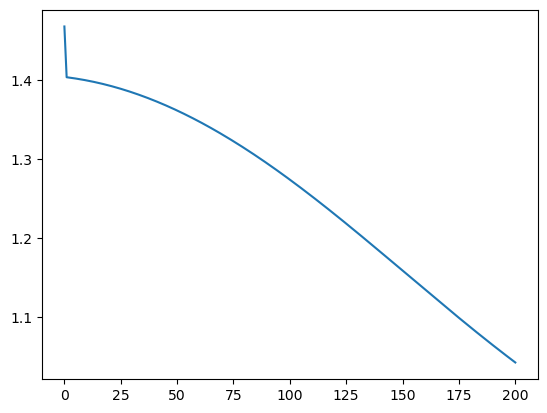

In [13]:
lstm_loss,lstm_tot_loss,lstm_time=LSTM_iter(W,Y,x,batchsize,DIM,device,rec_num=0,standard='mean',acc=1e-6,plot=True)

## Train LSTM

In [14]:
def RUN(W,Y,x,batchsize,DIM,steps=40,eps=10,reset=True):
    if reset:
        x = torch.zeros((batchsize,DIM),device=device,requires_grad=True)
    x.requires_grad=True
    state=None#初始化LSTM hidden state
    H=torch.eye(DIM, device=x.device, dtype=x.dtype,requires_grad=True).unsqueeze(0).expand(batchsize, -1, -1)
    mem_loss=[]#初始化loss的list
    loss=logistic(W,Y,x,2,DIM)#每个case的loss
    global_loss_graph = 0#记录每个迭代的总loss 用于后向传播
    lossmean=loss.mean()#总loss的平均值

    global_loss_graph+=lossmean
    mem_loss.append(lossmean.clone().detach())
    lossmean.backward(retain_graph=True)
    g = x.grad.clone()#g detach掉
    d=-torch.matmul(H,g.unsqueeze(2))
    k=0
    #print(loss)
    for i in range(steps):
        g_pre=g.clone()# 保存g作为上一次的g，此时g_pre不在计算图中
        alpha=strong_wolfe(W,Y,batchsize,f, x, d, loss, g, c1=1e-4, c2=0.9, max_iter=10,device=device)
        alpha.detach_()
        update=alpha*d.squeeze()
        # update=d.squeeze()
        x=x+update
        x.retain_grad()
        loss=logistic(W,Y,x,2,DIM)
        lossmean=loss.mean()
        global_loss_graph+=lossmean
        mem_loss.append(lossmean.clone().detach())
        #print(mem_loss[0])
        lossmean.backward(retain_graph=True)
        #print([i.grad for i in LSTM_motify.parameters()])
        #print(g)
        g = x.grad.clone()
        #print(torch.norm(g,dim=1).mean())
        if(sum(torch.norm(g,dim=1)<acc)>0):
            break
        #print(B.H)
        input_vec=torch.cat((g,update),dim=1).unsqueeze(0)
        #print(input_vec.is_leaf)
        motify,state=LSTM_motify(input_vec,state)
        deltaH=motify.reshape((batchsize, DIM, 1))
        H = H.clone().detach() + deltaH*deltaH.transpose(1, 2)
        H.retain_grad()
        d=-torch.matmul(H,g.unsqueeze(2))
        k+=1
    # plt.plot([i.cpu().detach().numpy() for i in mem_loss],label='LSTM_before_train')

    return mem_loss,global_loss_graph,x

In [15]:
def global_training(Global_Train_Steps,substeps,eachsteps,motifier):
    global_loss_list = []    
    adam_global_optimizer = torch.optim.Adam(motifier.parameters(),lr = 0.0001)
    W = torch.randn((batchsize, DIM, DIM), device=device) # represents IID
    Y = torch.rand((batchsize,DIM),device=device)
    x = torch.ones((batchsize,DIM),device=device,requires_grad=True)
    _,global_loss_1,x = RUN(W,Y,x,batchsize,DIM,steps=eachsteps)
    print(global_loss_1)
    for i in tqdm(range(Global_Train_Steps)):
        W = torch.randn((batchsize, DIM, DIM), device=device) # represents IID
        Y = torch.rand((batchsize,DIM),device=device)
        subiterloss=0
        for j in range(substeps):
            resetflag=(j==0)
            _,global_loss,x = RUN(W,Y,x.clone().detach(),batchsize,DIM,steps=eachsteps,reset=resetflag)
            subiterloss+=global_loss
            adam_global_optimizer.zero_grad()
            global_loss.backward() #每次都是优化这个固定的图，不可以释放动态图的缓存
            #print('xxx',[z.shape for z in motifier.parameters()  ])
            adam_global_optimizer.step()
        #print('iteration:{},mean_loss:{}'.format(i,subiterloss))
        #print('xxx',[(z.grad,z.requires_grad) for z in motifier.parameters()  ])
        global_loss_list.append(global_loss.detach_())
        
    print(global_loss)
    return global_loss_list


In [26]:
global_training(2000,4,100,LSTM_motify)

tensor(-10.2190, device='cuda:0', grad_fn=<AddBackward0>)


 63%|██████▎   | 1253/2000 [4:17:27<2:33:29, 12.33s/it]


KeyboardInterrupt: 

In [17]:
# W = torch.randn((batchsize, DIM, DIM), device=device) # represents IID
# Y = torch.randn((batchsize,DIM),device=device)
# x = torch.zeros((batchsize,DIM),device=device,requires_grad=True)

# state=None#初始化LSTM hidden state
# H=torch.eye(DIM, device=x.device, dtype=x.dtype,requires_grad=True).unsqueeze(0).expand(batchsize, -1, -1)
# steps=20
# mem_loss=[]#初始化loss的list
# loss=f(W,Y,x)#每个case的loss
# global_loss_graph = 0#记录每个迭代的总loss 用于后向传播
# lossmean=loss.mean()#总loss的平均值

# global_loss_graph+=lossmean
# mem_loss.append(lossmean.clone().detach())

# lossmean.backward(retain_graph=True)
# g = x.grad.clone()#g detach掉
# d=-torch.matmul(H,g.unsqueeze(2))
# k=0
# #print(loss)
# for i in range(steps):
#     g_pre=g.clone()# 保存g作为上一次的g，此时g_pre不在计算图中
#     # alpha=strong_wolfe(W,Y,batchsize,f, x, d, loss, g, c1=1e-4, c2=0.9, max_iter=10,device=device)
#     # alpha.detach_()
#     # update=alpha*d.squeeze()
#     update=d.squeeze()
#     x=x+update
#     x.retain_grad()
#     loss=f(W,Y,x)
#     lossmean=loss.mean()
#     global_loss_graph+=lossmean
#     mem_loss.append(lossmean.clone().detach())
#     #print(mem_loss[0])
#     lossmean.backward(retain_graph=True)
#     print([i.grad for i in LSTM_motify.parameters()])
#     #print(g)
#     g = x.grad.clone()
#     #print(torch.norm(g,dim=1).mean())
#     if(sum(torch.norm(g,dim=1)<acc)>0):
#         break
#     #print(B.H)
#     input_vec=torch.cat((g,update),dim=1).unsqueeze(0)
#     #print(input_vec.is_leaf)
#     motify,state=LSTM_motify(input_vec,state)
#     H = H.clone() + motify.reshape((batchsize, DIM, DIM))
#     H.retain_grad()
#     d=-torch.matmul(H,g.unsqueeze(2))
#     k+=1
# plt.plot([i.cpu().detach().numpy() for i in mem_loss],label='LSTM_before_train')

In [25]:
W = torch.randn((batchsize, DIM, DIM), device=device) # represents IID
Y = torch.randn((batchsize,DIM),device=device)
x = torch.zeros((batchsize,DIM),device=device,requires_grad=True)
steps=40
state=None
H=BFGS(batchsize,DIM,device,x).I
mem_loss=[]
loss=f(W,Y,x)
acc=1e-6
mem_loss.append(loss.mean())
g=torch.autograd.grad(loss.mean(),x)[0]
d=-torch.matmul(B.H,g.unsqueeze(2))
k=0
#print(loss)
for i in range(steps):
    g_pre=g
    alpha=strong_wolfe(W,Y,batchsize,f, x, d, loss, g, c1=1e-4, c2=0.9, max_iter=10,device=device)
    update=alpha*(d.squeeze())
    x=x+update
    loss=f(W,Y,x)
    mem_loss.append(loss.mean())
    g=torch.autograd.grad(loss.mean(),x)[0]
    #print(torch.norm(g,dim=1).mean())
    if(sum(torch.norm(g,dim=1)<acc)>0):
        break
    d=-torch.matmul(H,g.unsqueeze(2))
    #print(B.H)
    input_vec=torch.cat((g,update),dim=1).unsqueeze(0)
    motify,state=LSTM_motify(input_vec,state)
    delta_H=motify.reshape((batchsize, DIM, DIM))
    H = H.clone().detach() + 1/2*(delta_H+delta_H.transpose(-2,-1))
    k+=1
    
print(k)    
plt.plot([i.cpu().detach().numpy() for i in mem_loss],label='LSTM_before_train')  
x = torch.zeros((batchsize,DIM),device=device,requires_grad=True)
steps=40
B=BFGS(batchsize,DIM,device)
mem_loss=[]
loss=f(W,Y,x)
acc=1e-6
mem_loss.append(loss.mean())
g=torch.autograd.grad(loss.mean(),x)[0]
d=-torch.matmul(B.H,g.unsqueeze(2))
k=0
#print(loss)
for i in range(steps):
    g_pre=g
    alpha=strong_wolfe(W,Y,batchsize,f, x, d, loss, g, c1=1e-4, c2=0.9, max_iter=10,device=device)
    update=alpha*(d.squeeze())
    x=x+update
    loss=f(W,Y,x)
    mem_loss.append(loss.mean())
    g=torch.autograd.grad(loss.mean(),x)[0]
    #print(torch.norm(g,dim=1).mean())
    if(sum(torch.norm(g,dim=1)<acc)>0):
        break
    d=-torch.matmul(B.H,g.unsqueeze(2))
    #print(B.H)
    B.H_BFDS_update(update,g-g_pre)
    k+=1
    
print(k)    
plt.plot([i.cpu().detach().numpy() for i in mem_loss],label='BFGS')  
plt.legend()

plt.show()

IndexError: The shape of the mask [128] at index 0 does not match the shape of the indexed tensor [1, 1] at index 0